In [1]:
import json
import os
import numpy as np
import seaborn as sns
import sys
import ssm
import matplotlib.pyplot as plt
from post_processing_utils import load_data, load_glmhmm_data, load_cv_arr, \
    create_cv_frame_for_plotting, get_file_name_for_best_model_fold, \
    permute_transition_matrix, calculate_state_permutation, partition_data_by_session,\
    get_marginal_posterior


**ALL ANIMAL FIT**

In [2]:
data_dir = '/Users/cecelia/Desktop/glm-hmm/data/data_for_cluster/'
results_dir = '/Users/cecelia/Desktop/glm-hmm/results/global_fit'
inpt, y, session = load_data(data_dir + 'all_animals_concat.npz')
inpt = np.hstack((inpt, np.ones((len(inpt),1))))
inpt.shape

(1539, 10)

In [3]:
obs_dim = 1
input_dim = 10
prior_alpha = 2
prior_sigma = 2
C=2

**FIT GLM-HMM 2 states**

In [4]:
num_states = 2
new_glmhmm_2 = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=C, prior_sigma=prior_sigma), 
                   transitions="sticky",transition_kwargs=dict(alpha=prior_alpha,kappa=0))

N_iters = 300 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll_2 = new_glmhmm_2.fit([y], [inpt], method="em", num_iters=N_iters, initialize=False, tolerance=10**-4)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GLM-HMM Weight')

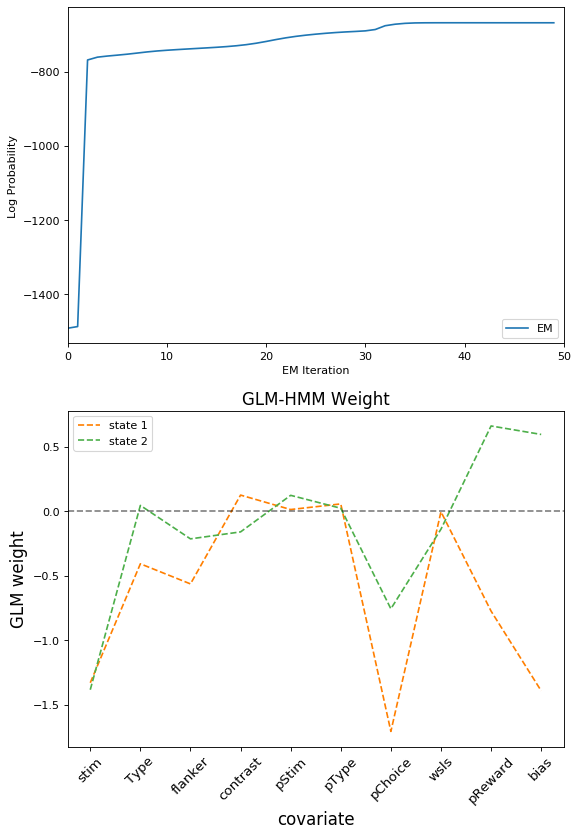

In [8]:
fig = plt.figure(figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 1, 1)
plt.plot(fit_ll_2, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll_2))
plt.ylabel("Log Probability")

plt.subplot(2, 1, 2)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#70587C', '#00A5CF']
labels_for_plot = [ 'stim', 'Type', 'flanker',\
                       'contrast', 'pStim',\
                       'pType','pChoice', \
                       'wsls', 'pReward', 'bias']

recovered_weights_2 = new_glmhmm_2.observations.params
for k in range(num_states):
        plt.plot(range(input_dim), recovered_weights_2[k][0], color=cols[k],
                     lw=1.5,  label = 'state ' + str(k+1), linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels_for_plot, fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("GLM-HMM Weight", fontsize=15)

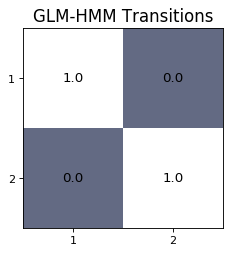

In [9]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
trans_mat_2 = np.exp(new_glmhmm_2.transitions.log_Ps)
plt.imshow(trans_mat_2, vmin=-0.8, vmax=1, cmap='bone')
for i in range(trans_mat_2.shape[0]):
    for j in range(trans_mat_2.shape[1]):
        text = plt.text(j, i, str(np.around(trans_mat_2[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("GLM-HMM Transitions", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


In [10]:
new_glmhmm_2.expected_states(data=y, input=inpt)[0]

array([[6.70375379e-11, 1.00000000e+00],
       [4.91752180e-06, 9.99995082e-01],
       [3.10818746e-04, 9.99689181e-01],
       ...,
       [9.99744098e-01, 2.55902375e-04],
       [9.99227617e-01, 7.72382603e-04],
       [9.98706204e-01, 1.29379627e-03]])

Text(0, 0.5, 'p(state)')

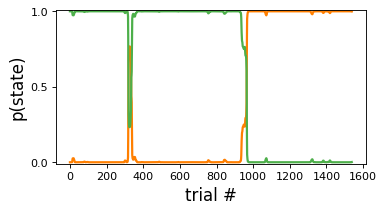

In [11]:
# Get expected states:
posterior_probs_2 = new_glmhmm_2.expected_states(data=y, input=inpt)[0]
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(2):
    plt.plot(posterior_probs_2[:,k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

In [12]:
# concatenate posterior probabilities across sessions
posterior_probs_concat_2 = np.concatenate(posterior_probs_2)
# get state with maximum posterior probability at particular trial:
state_max_posterior_2 = np.argmax(posterior_probs_concat_2, axis = 0)
# now obtain state fractional occupancies:
_, state_occupancies_2 = np.unique(state_max_posterior_2, return_counts=True)
state_occupancies_2 = state_occupancies_2/np.sum(state_occupancies_2)

Text(0, 0.5, 'frac. occupancy')

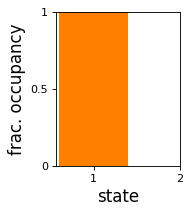

In [13]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies_2):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1], ['1', '2'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

**FIT GLM-HMM 3 states**

In [15]:
num_states = 3
obs_dim = 1
input_dim = 10
new_glmhmm_3 = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=C, prior_sigma=prior_sigma), 
                   transitions="sticky",transition_kwargs=dict(alpha=prior_alpha,kappa=0))

N_iters = 300 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll_3 = new_glmhmm_3.fit([y], [inpt], method="em", num_iters=N_iters, initialize=False, tolerance=10**-4)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GLM-HMM Weight')

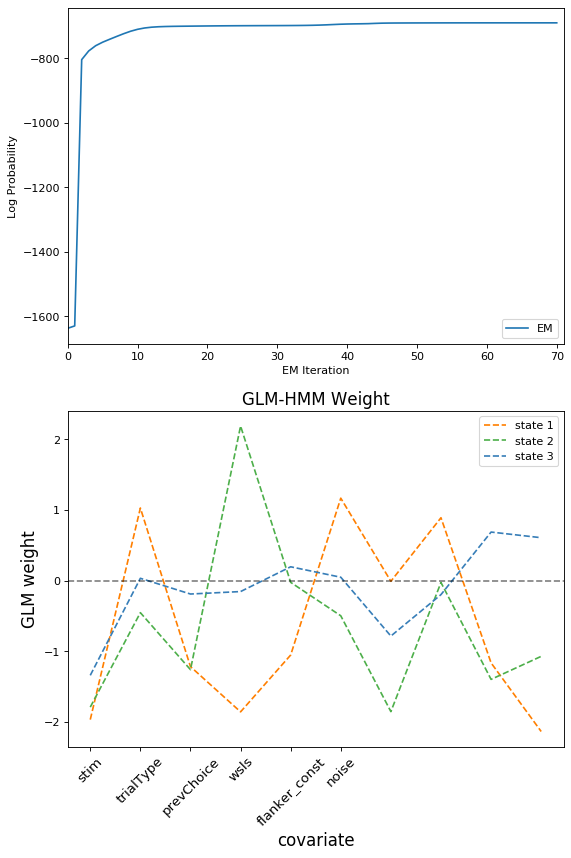

In [16]:
fig = plt.figure(figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 1, 1)
plt.plot(fit_ll_3, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll_3))
plt.ylabel("Log Probability")

plt.subplot(2, 1, 2)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#70587C', '#00A5CF']
labels_for_plot = [ 'stim', 'trialType', 'prevChoice','wsls', 'flanker_const', 'noise']
recovered_weights_3 = new_glmhmm_3.observations.params
for k in range(num_states):
        plt.plot(range(input_dim), recovered_weights_3[k][0], color=cols[k],
                     lw=1.5,  label = 'state ' + str(k+1), linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1, 2, 3, 4, 5], labels_for_plot, fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("GLM-HMM Weight", fontsize=15)

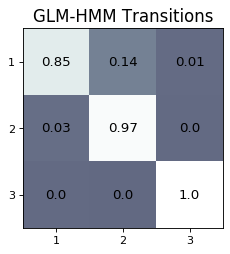

In [17]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
trans_mat_3 = np.exp(new_glmhmm_3.transitions.log_Ps)
plt.imshow(trans_mat_3, vmin=-0.8, vmax=1, cmap='bone')
for i in range(trans_mat_3.shape[0]):
    for j in range(trans_mat_3.shape[1]):
        text = plt.text(j, i, str(np.around(trans_mat_3[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("GLM-HMM Transitions", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


Text(0, 0.5, 'p(state)')

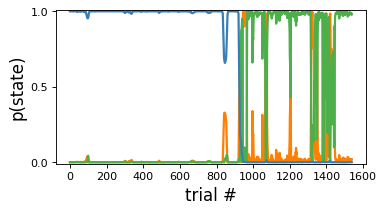

In [18]:
# Get expected states:
posterior_probs_3 = new_glmhmm_3.expected_states(data=y, input=inpt)[0]
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(3):
    plt.plot(posterior_probs_3[:,k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

In [25]:
# concatenate posterior probabilities across sessions
posterior_probs_concat_3 = np.concatenate(posterior_probs_3)
# get state with maximum posterior probability at particular trial:
state_max_posterior_3 = np.argmax(posterior_probs_concat_3, axis = 0)
# now obtain state fractional occupancies:
_, state_occupancies_3 = np.unique(state_max_posterior_3, return_counts=True)
state_occupancies_3 = state_occupancies_3/np.sum(state_occupancies_3)

Text(0, 0.5, 'frac. occupancy')

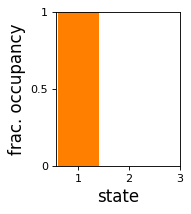

In [26]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies_3):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

TEMP: FIT MORE THAN 3 STATES

In [27]:
num_states = 4
obs_dim = 1
input_dim = 10
new_glmhmm_3 = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=C, prior_sigma=prior_sigma), 
                   transitions="sticky",transition_kwargs=dict(alpha=prior_alpha,kappa=0))

N_iters = 300 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll_3 = new_glmhmm_3.fit([y], [inpt], method="em", num_iters=N_iters, initialize=False, tolerance=10**-4)

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GLM-HMM Weight')

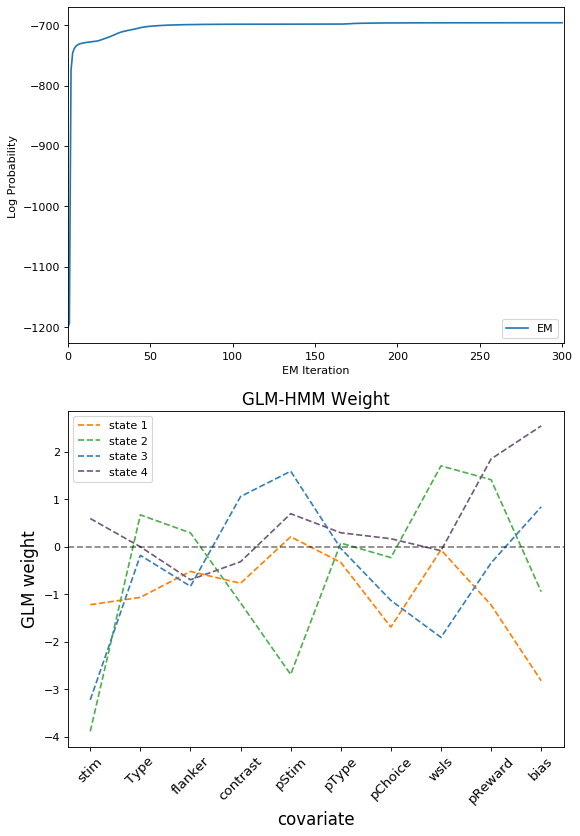

In [31]:
fig = plt.figure(figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 1, 1)
plt.plot(fit_ll_3, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll_3))
plt.ylabel("Log Probability")

plt.subplot(2, 1, 2)
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#70587C', '#00A5CF']
labels_for_plot = [ 'stim', 'Type', 'flanker',\
                       'contrast', 'pStim',\
                       'pType','pChoice', \
                       'wsls', 'pReward', 'bias']
recovered_weights_3 = new_glmhmm_3.observations.params
for k in range(num_states):
        plt.plot(range(input_dim), recovered_weights_3[k][0], color=cols[k],
                     lw=1.5,  label = 'state ' + str(k+1), linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels_for_plot, fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("GLM-HMM Weight", fontsize=15)

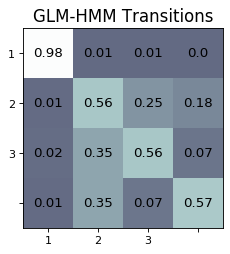

In [32]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
trans_mat_3 = np.exp(new_glmhmm_3.transitions.log_Ps)
plt.imshow(trans_mat_3, vmin=-0.8, vmax=1, cmap='bone')
for i in range(trans_mat_3.shape[0]):
    for j in range(trans_mat_3.shape[1]):
        text = plt.text(j, i, str(np.around(trans_mat_3[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("GLM-HMM Transitions", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


Text(0, 0.5, 'p(state)')

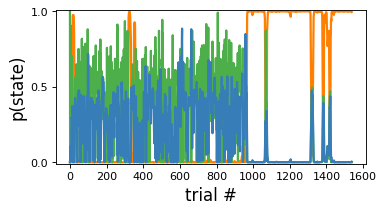

In [33]:
# Get expected states:
posterior_probs_3 = new_glmhmm_3.expected_states(data=y, input=inpt)[0]
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(3):
    plt.plot(posterior_probs_3[:,k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)